In [9]:
import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(6)
tf.config.threading.set_inter_op_parallelism_threads(6)


In [10]:
import scipy.io
import numpy as np
import mne
import os
import gym
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

In [11]:
# download_url = [
#     "https://www.bbci.de/competition/download/competition_iv/BCICIV_2a_gdf.zip"
# ]

# for i in download_url:
#     os.system("wget --no-check-certificate -P /mnt/Data/Data/EEG_Converted "+i)

In [12]:


from tensorflow import keras
from keras import layers
import time

dataset = []
labels = []
multigrasp_dataset = []
reaching_dataset = []
twist_dataset = []
for filename in os.listdir('/mnt/Data/Data/EEG_Converted'):
    if 'MI' in filename:
        filepath = os.path.join('/mnt/Data/Data/EEG_Converted', filename)
        data = scipy.io.loadmat(filepath)
        data.pop('__header__')
        data.pop('__version__')
        data.pop('__globals__')
        data.pop('mrk')
        data.pop('mnt')
        data.pop('nfo')
        data.pop('dat')
        
        data_arr = np.array(data['ch15'])
        for ch in range(16, 19):
            data_arr = np.concatenate((data_arr, data['ch'+str(ch)]), axis=1)
        for ch in range(43, 46):
            data_arr = np.concatenate((data_arr, data['ch'+str(ch)]), axis=1)
        data_arr = data_arr.T
        if 'multigrasp_MI' in filename:
            multigrasp_dataset.append(data_arr)
        if 'reaching_MI' in filename:
            reaching_dataset.append(data_arr)
        if 'twist_MI' in filename:
            twist_dataset.append(data_arr)



In [13]:
# min_multigrasp_len = min([multigrasp_dataset[i].shape for i in range(len(multigrasp_dataset))])
# min_reaching_len = min([reaching_dataset[i].shape for i in range(len(reaching_dataset))])
# min_twist_len = min([twist_dataset[i].shape for i in range(len(twist_dataset))])
#print(min_multigrasp_len,min_reaching_len,min_twist_len)
def minimum_len(dataset):
    return min([dataset[i].shape for i in range(len(dataset))])

In [14]:
def read_data(dataset):
    for i in range(len(dataset)):
        dataset[i] = np.resize(dataset[i],(7,65536))
        d = dataset[i].astype(float)
        dataset[i] = mne.filter.filter_data(d, l_freq=0.1, h_freq=50,sfreq=2500)
        print(d.shape)
        
    dataset = np.array(dataset)
    print(dataset.shape)
    return dataset


In [15]:

#chan_names = ['Fp1','AF7','AF3','AFz','F7','F5','F3','F1','Fz','FT7','FC5','FC3','FC1','T7','C5','C3','C1','Cz','TP7','CP5','CP3','CP1','CPz','P7','P5','P3','P1','Pz','PO7','PO3','POz','Fp2','AF4','AF8','F2','F4','F6','F8','FC2','FC4','FC6','FT8','C2','C4','C6','T8','CP2','CP4','CP6','TP8','P2','P4','P6','P8','PO4','PO8','O1','Oz','O2','Iz']
chan_names = ['C5','C3','C1','Cz','C2','C4','C6']
info = mne.create_info(ch_names=chan_names, ch_types=['eeg']*7, sfreq=2500)
info.set_montage('standard_1020')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: C5, C3, C1, Cz, C2, C4, C6
 chs: 7 EEG
 custom_ref_applied: False
 dig: 10 items (3 Cardinal, 7 EEG)
 highpass: 0.0 Hz
 lowpass: 1250.0 Hz
 meas_date: unspecified
 nchan: 7
 projs: []
 sfreq: 2500.0 Hz
>


In [16]:
%%capture

multigrasp_epochs = mne.EpochsArray(data=read_data(multigrasp_dataset), info=info)
reaching_epochs = mne.EpochsArray(data=read_data(reaching_dataset), info=info)
twist_epochs = mne.EpochsArray(data=read_data(twist_dataset), info=info)

In [17]:
import matplotlib
from mne.time_frequency import tfr_morlet
%matplotlib inline
print(len(multigrasp_dataset))
print(len(reaching_dataset))
print(len(twist_dataset))



# for i in range(10):
#     print("________________________________ ",i+1)
#     d = multigrasp_epochs.get_data()[i]
#     theta = mne.filter.filter_data(d, sfreq=2500, l_freq=4, h_freq=8,verbose=False)
#     alpha = mne.filter.filter_data(d, sfreq=2500, l_freq=8, h_freq=12,verbose=False)
#     beta = mne.filter.filter_data(d, sfreq=2500, l_freq=12, h_freq=30,verbose=False)
#     delta = mne.filter.filter_data(d, sfreq=2500, l_freq=0.5, h_freq=4,verbose=False)
#     t_evoked = mne.EvokedArray(theta, info, tmin=0)
#     a_evoked = mne.EvokedArray(alpha, info, tmin=0)
#     b_evoked = mne.EvokedArray(beta, info, tmin=0)
#     d_evoked = mne.EvokedArray(delta, info, tmin=0)
#     print("theta")
#     t_evoked.plot()
#     print("alpha")
#     a_evoked.plot()
#     print("beta")
#     b_evoked.plot()
#     print("delta")
#     d_evoked.plot()
    
#     print("________________________________ ")

36
36
36


In [18]:
import scipy.io
import numpy as np
import mne
import os
import gym
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

multigrasp_list = []
reaching_list=[]
twist_list = []
multigrasp_list.append(multigrasp_epochs.get_data())
reaching_list.append(reaching_epochs.get_data())
twist_list.append(twist_epochs.get_data())
multigrasp_labels = [0 for i in range(36)] #[0 for i in range(multigrasp_epochs.get_data().shape[0])]
print(multigrasp_labels)

reaching_labels = [1 for i in range(36)]
print(reaching_labels)

twist_labels = [2 for i in range(36)]
print(twist_labels)

label_list = multigrasp_labels + reaching_labels + twist_labels


multigrasp_array = np.vstack(multigrasp_list)
reaching_array = np.vstack(reaching_list)
twist_array = np.vstack(twist_list)

label_array = np.hstack(label_list)

print(label_array.shape)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
(108,)


In [19]:
#Functions for features
from scipy import stats
def mean(x):
    return np.mean(x,axis=-1)

def stddev(x):
    return np.std(x, axis=-1)

def peaktopeak(x):
    return np.ptp(x, axis=-1)

def variance(x):
    return np.var(x, axis=-1)

def mini(x):
    return np.min(x,axis=-1)

def maxi(x):
    return np.max(x,axis=-1)

def argmini(x):
    return np.argmin(x,axis=-1)

def argmaxi(x):
    return np.argmax(x,axis=-1)

def rms(x):
    return np.sqrt(np.mean(x**2,axis=-1))

def abs_diff_signal(x):
    return np.sum(np.abs(np.diff(x,axis=-1)),axis=-1)

def skewness(x):
    return stats.skew(x,axis=-1)

def kurtosis(x):
    return stats.kurtosis(x,axis=-1)

def concat_features(x):
    
    #print(mean_f.shape, mean_power.shape, peaktopeak(x).shape,rms(x).shape,abs_diff_signal(x).shape, skewness(x).shape, kurtosis(x).shape)
    return np.concatenate((peaktopeak(x),rms(x),abs_diff_signal(x), skewness(x), kurtosis(x), variance(x),mean(x),stddev(x)),axis=-1)

def featuresarray_load(data_array):
    features = []
    for d in data_array:
        #mean_power = np.mean(p,axis=0)
        theta = mne.filter.filter_data(d, sfreq=2500, l_freq=4, h_freq=8,verbose=False)
        alpha = mne.filter.filter_data(d, sfreq=2500, l_freq=8, h_freq=12,verbose=False)
        beta = mne.filter.filter_data(d, sfreq=2500, l_freq=12, h_freq=30,verbose=False)
        #delta = mne.filter.filter_data(d, sfreq=2500, l_freq=0.5, h_freq=4,verbose=False)
        alph_ftrs = concat_features(alpha)
        beta_ftrs = concat_features(beta)
        theta_ftrs = concat_features(theta)    
        #delta_ftrs = concat_features(delta)  
        f,p=scipy.signal.welch(beta, fs=2500,average='median')
        psd_c3 = p[1, :]  
        psd_c4 = p[5, :]  
        res = np.mean([alph_ftrs,beta_ftrs,theta_ftrs],axis=0)
        print('p',psd_c3.shape)
        res = np.concatenate((res,psd_c3,psd_c4))
        #print(res.shape)
        features.append(res)
    return features

f_mg = np.array(featuresarray_load(multigrasp_array))
f_rch = np.array(featuresarray_load(reaching_array))
f_tw = np.array(featuresarray_load(twist_array))
np.save("m_features_array3_65536.npy",allow_pickle=False,arr=f_mg)
np.save("r_features_array3_65536.npy",allow_pickle=False,arr=f_rch)
np.save("t_features_array3_65536.npy",allow_pickle=False,arr=f_tw)

p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)
p (129,)


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import GroupKFold, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
import matplotlib.pyplot as plt

314
(314,) 0


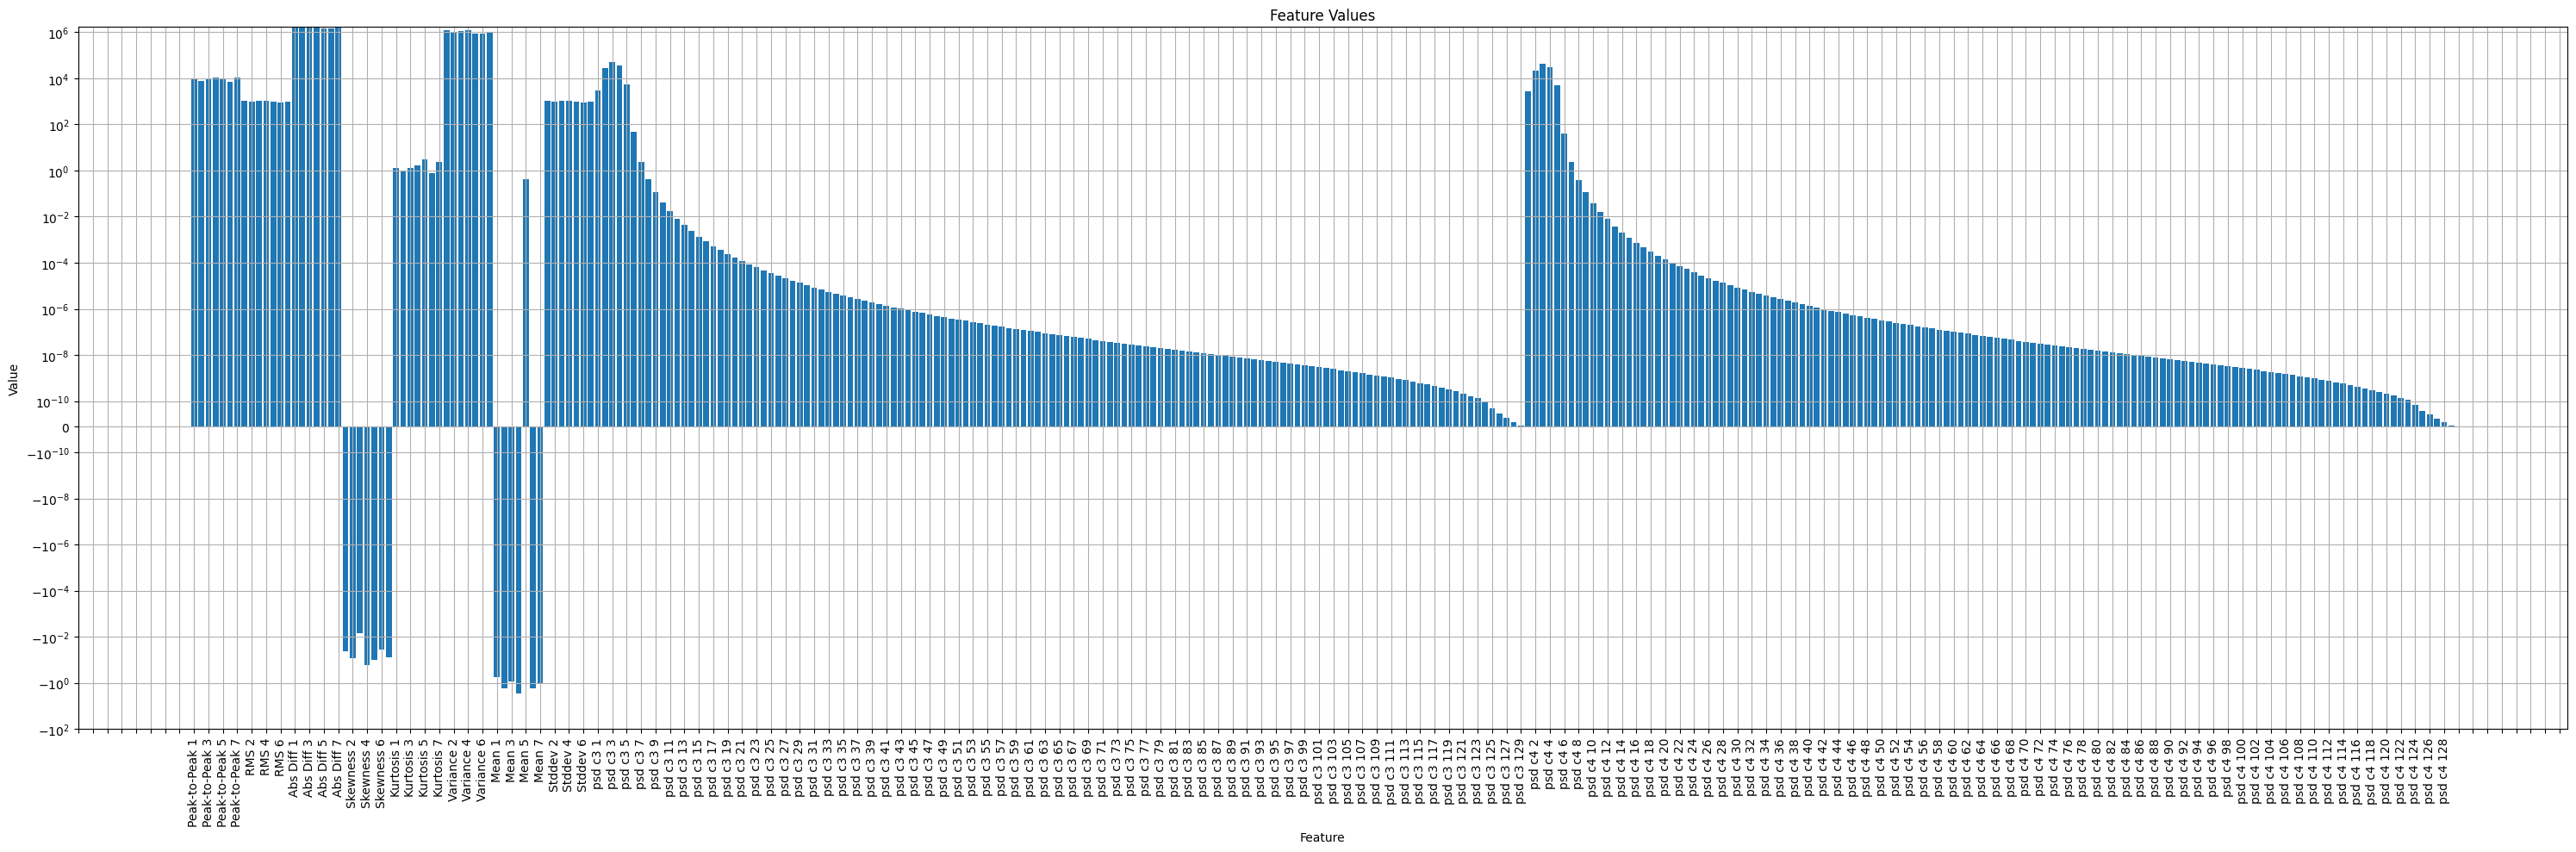

Plot 2 has been plotted
(314,) 1


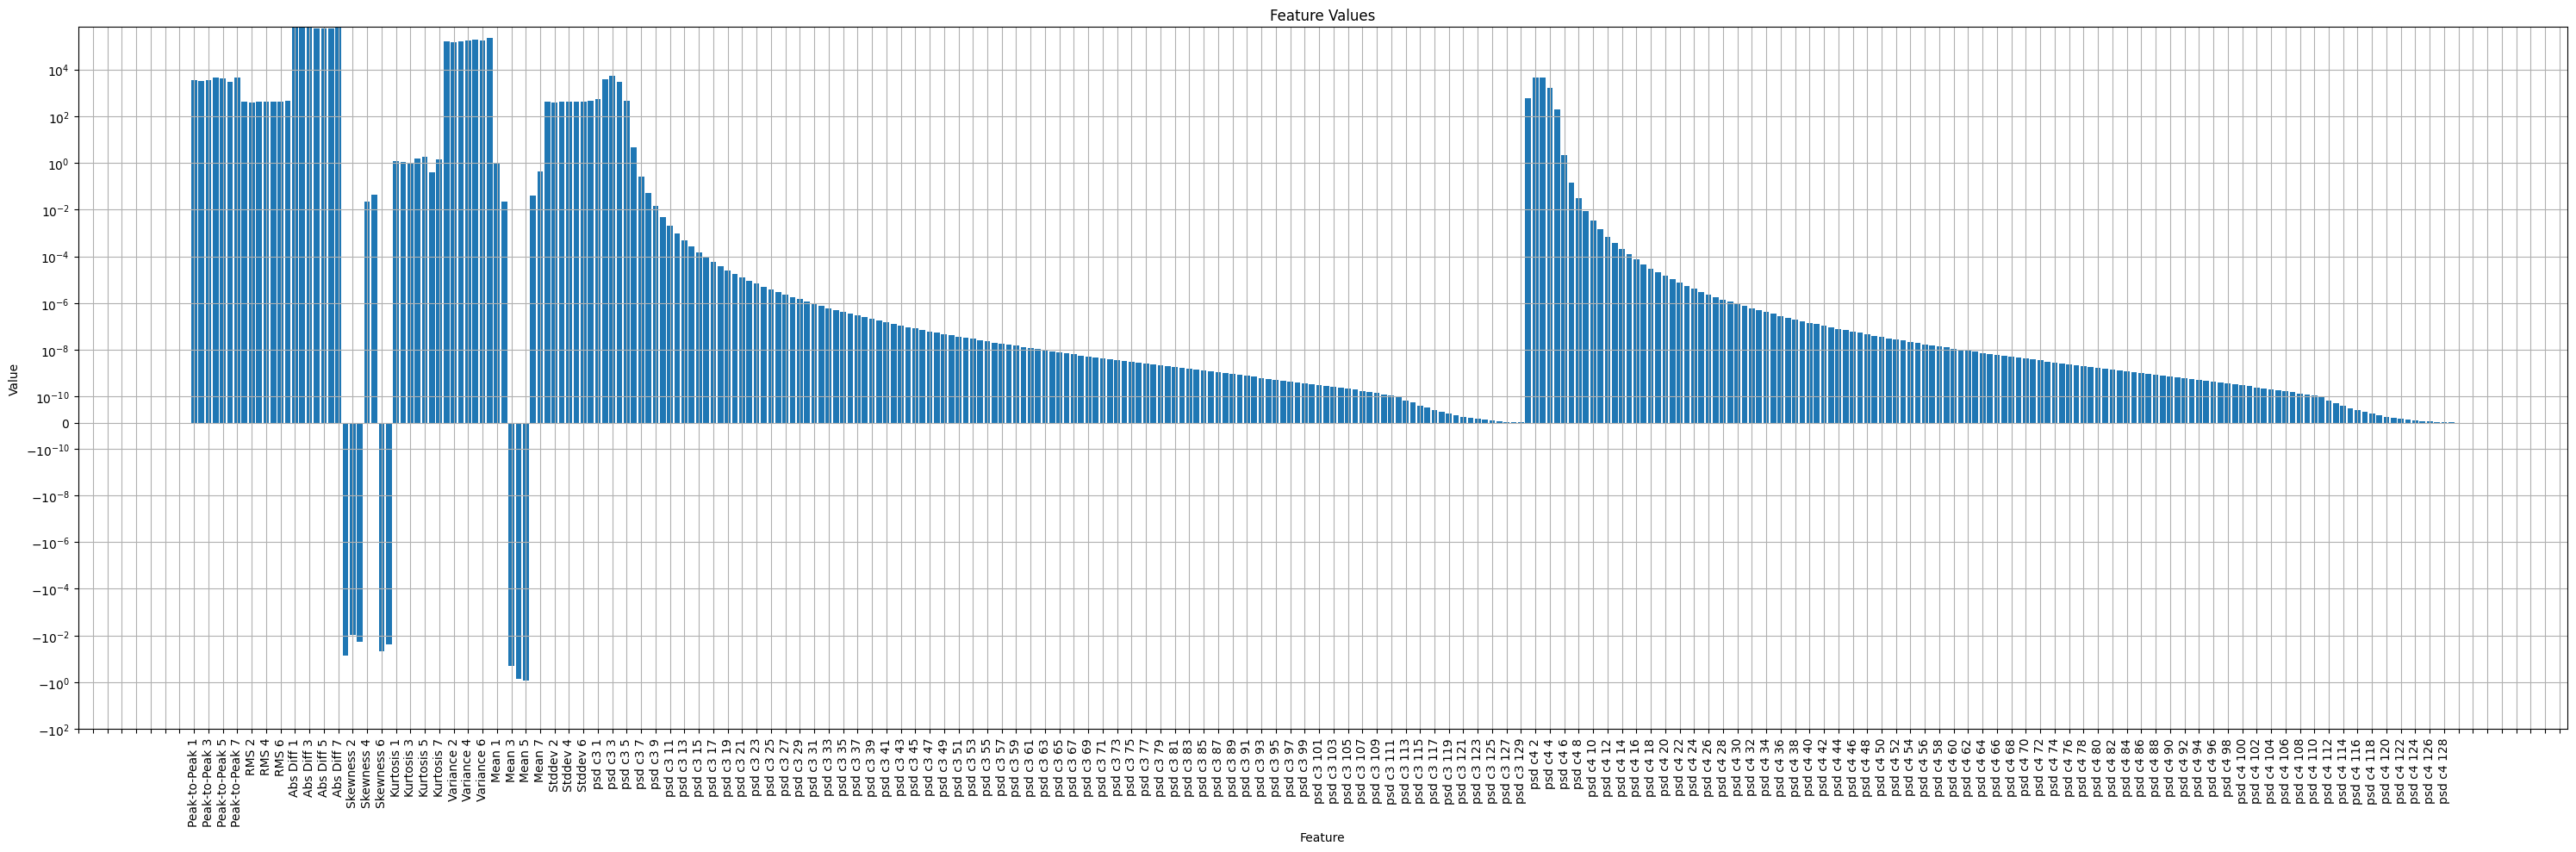

Plot 38 has been plotted
(314,) 2


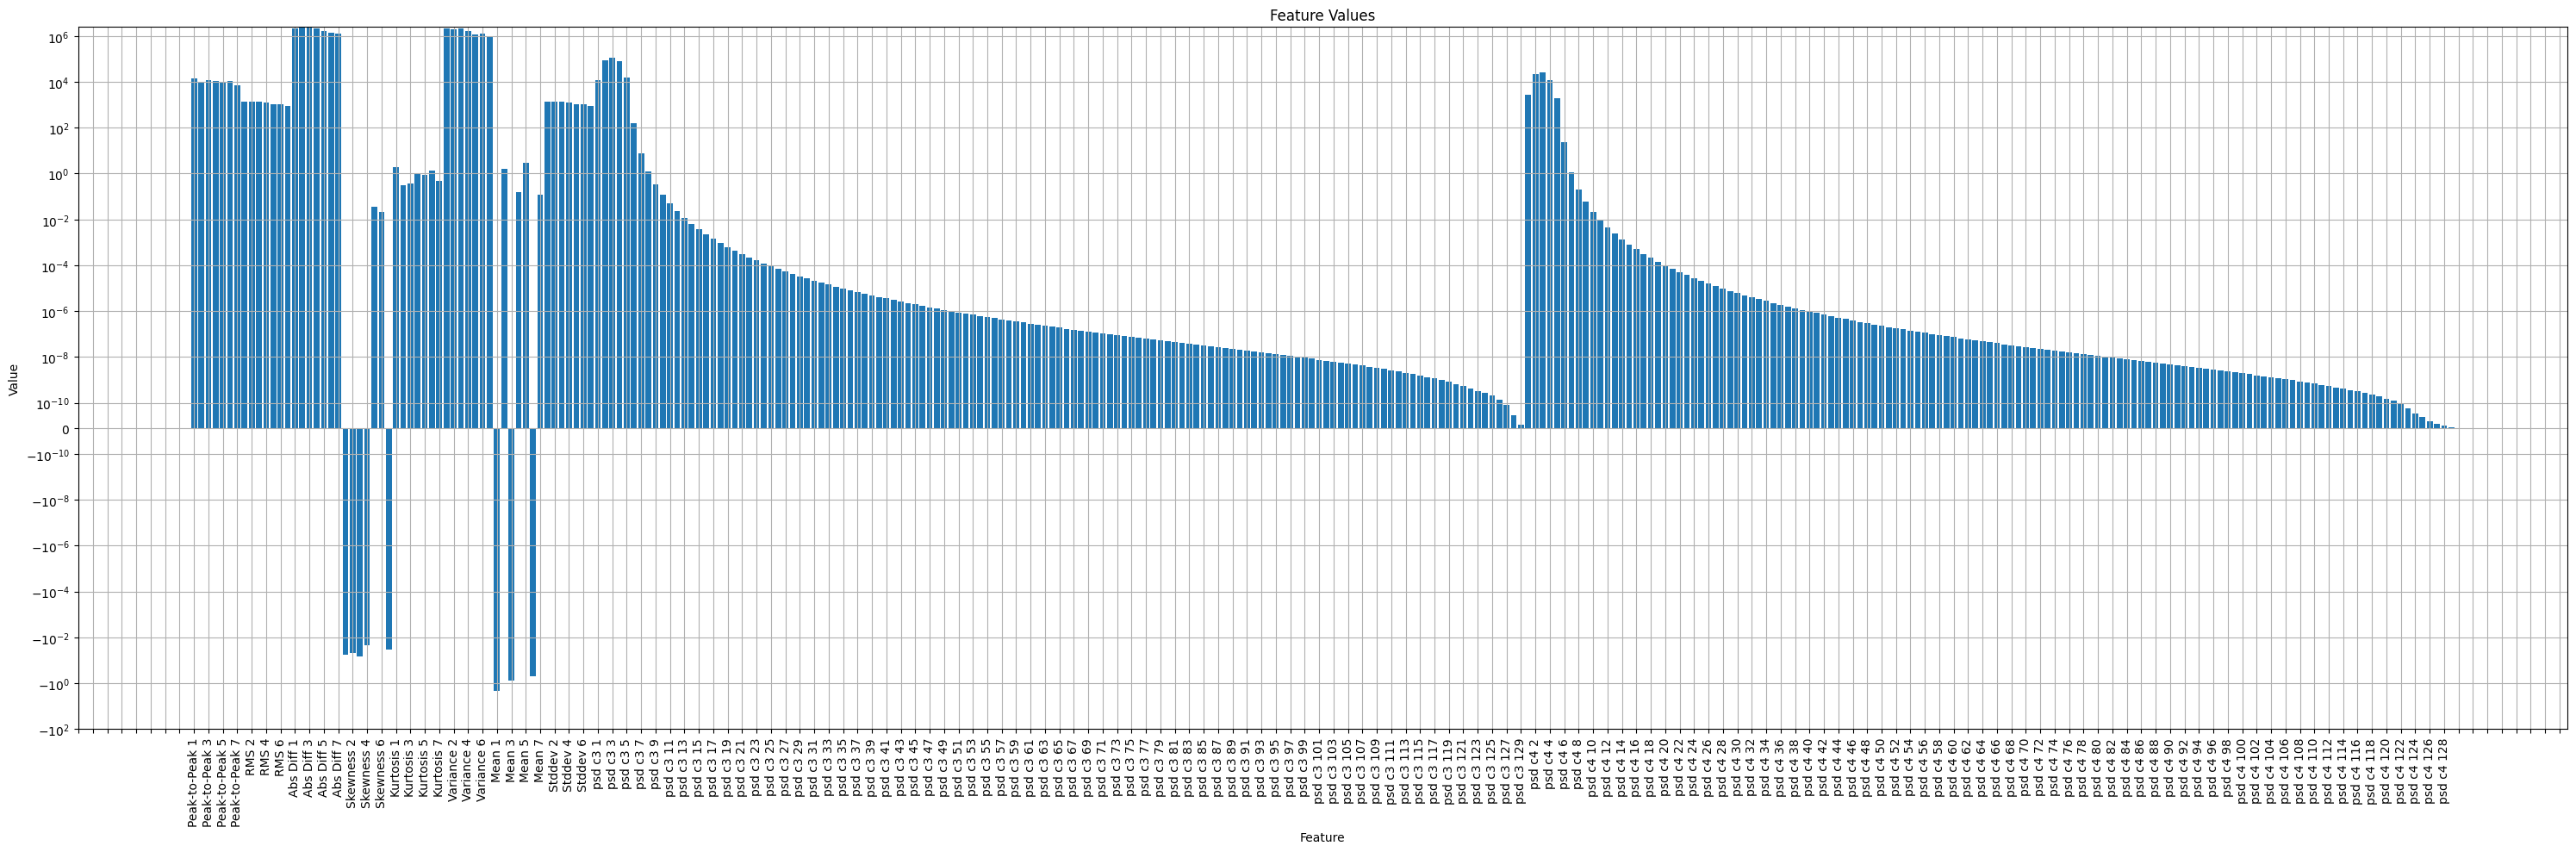

Plot 108 has been plotted
(314,) 0


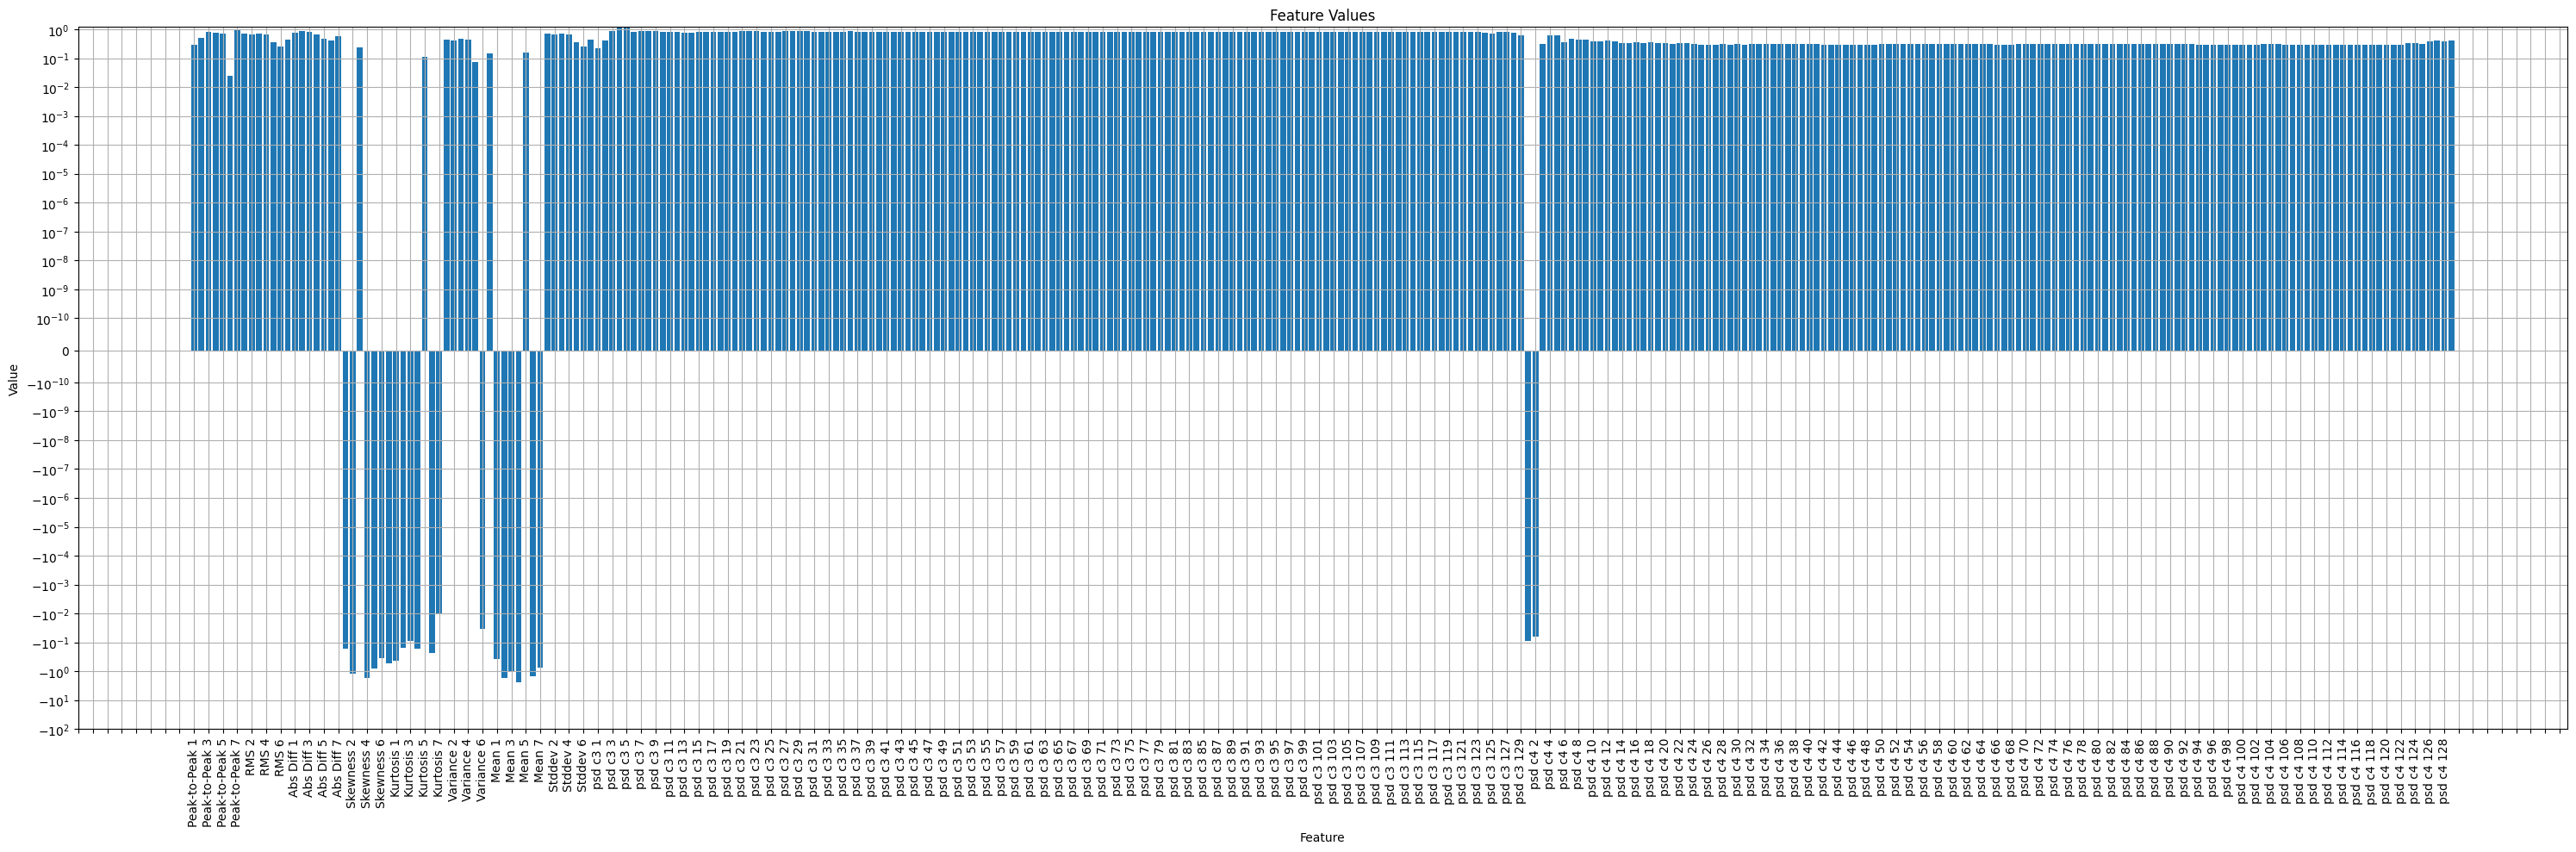

Plot 2 has been plotted
(314,) 1


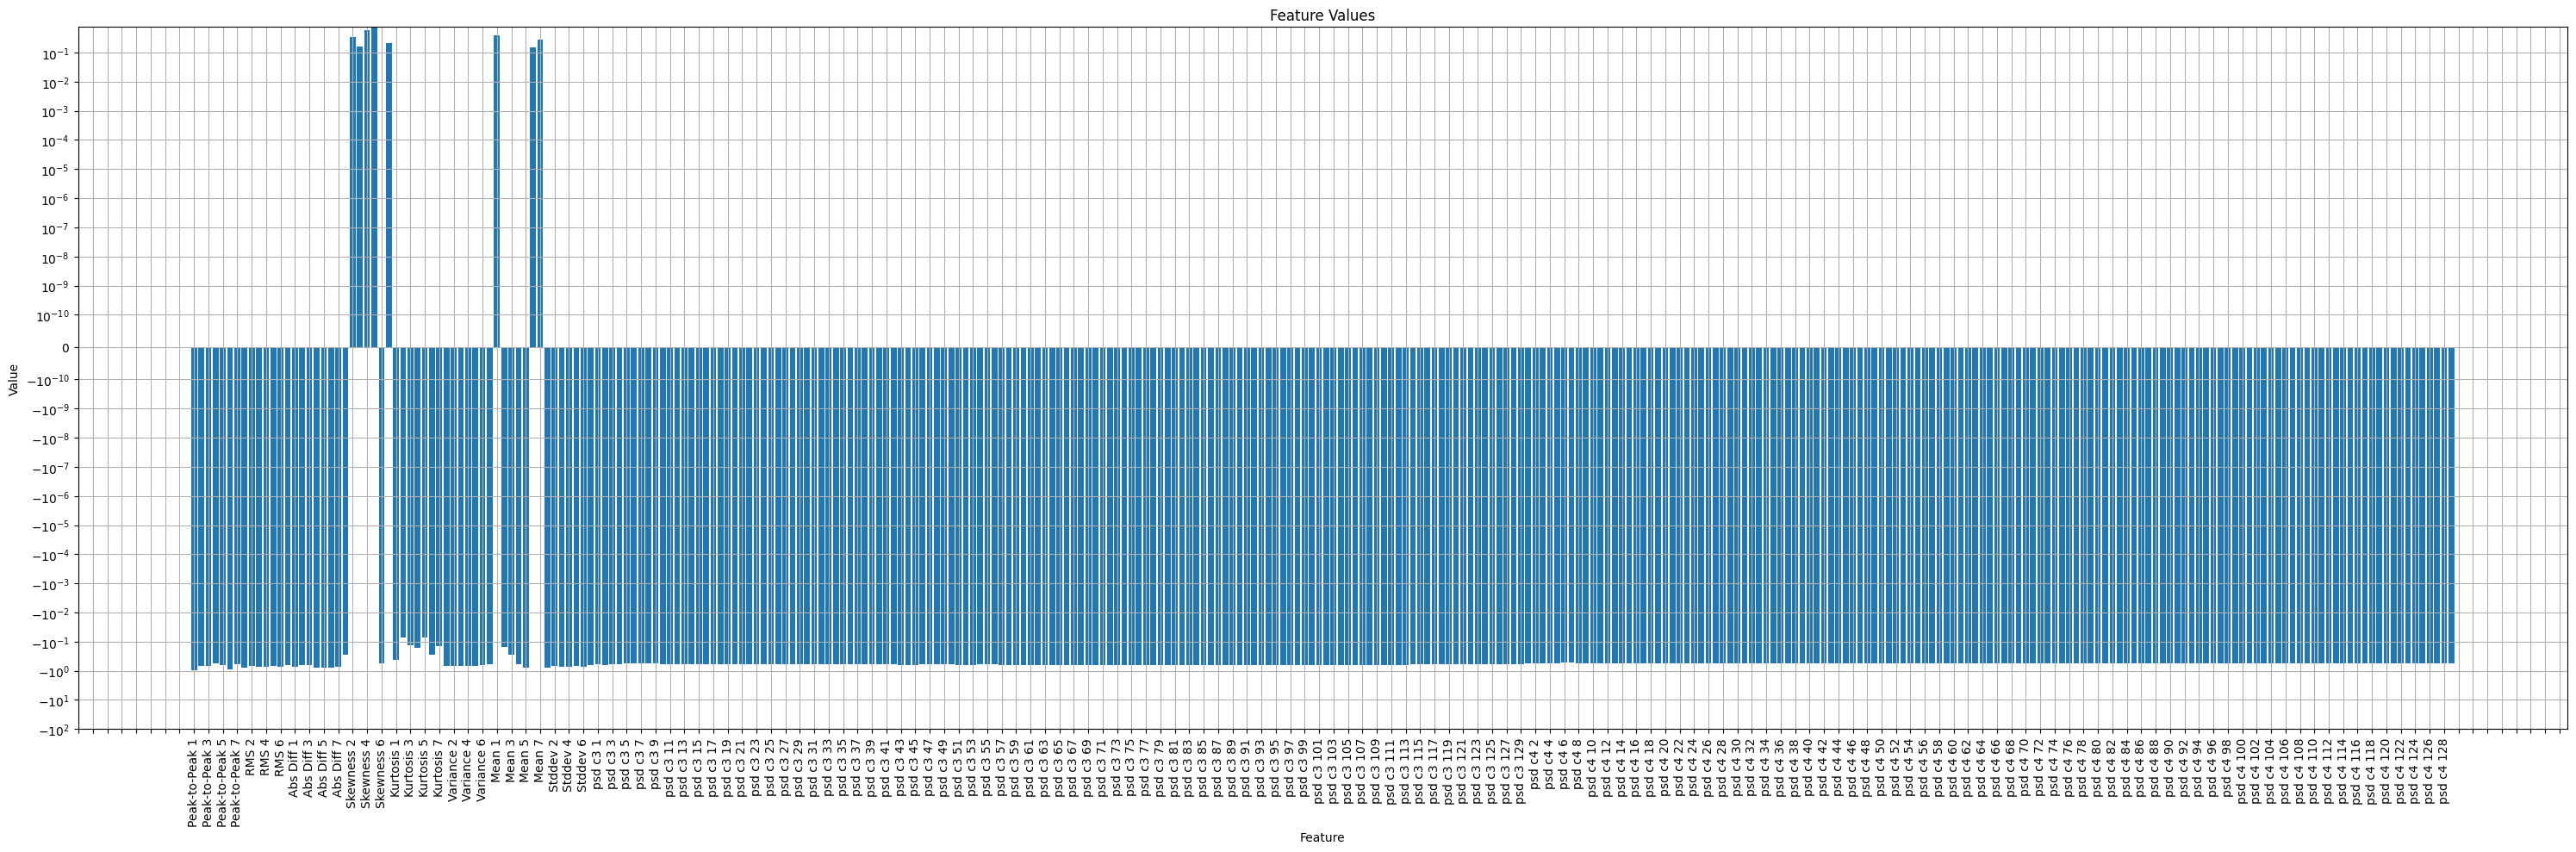

Plot 38 has been plotted
(314,) 2


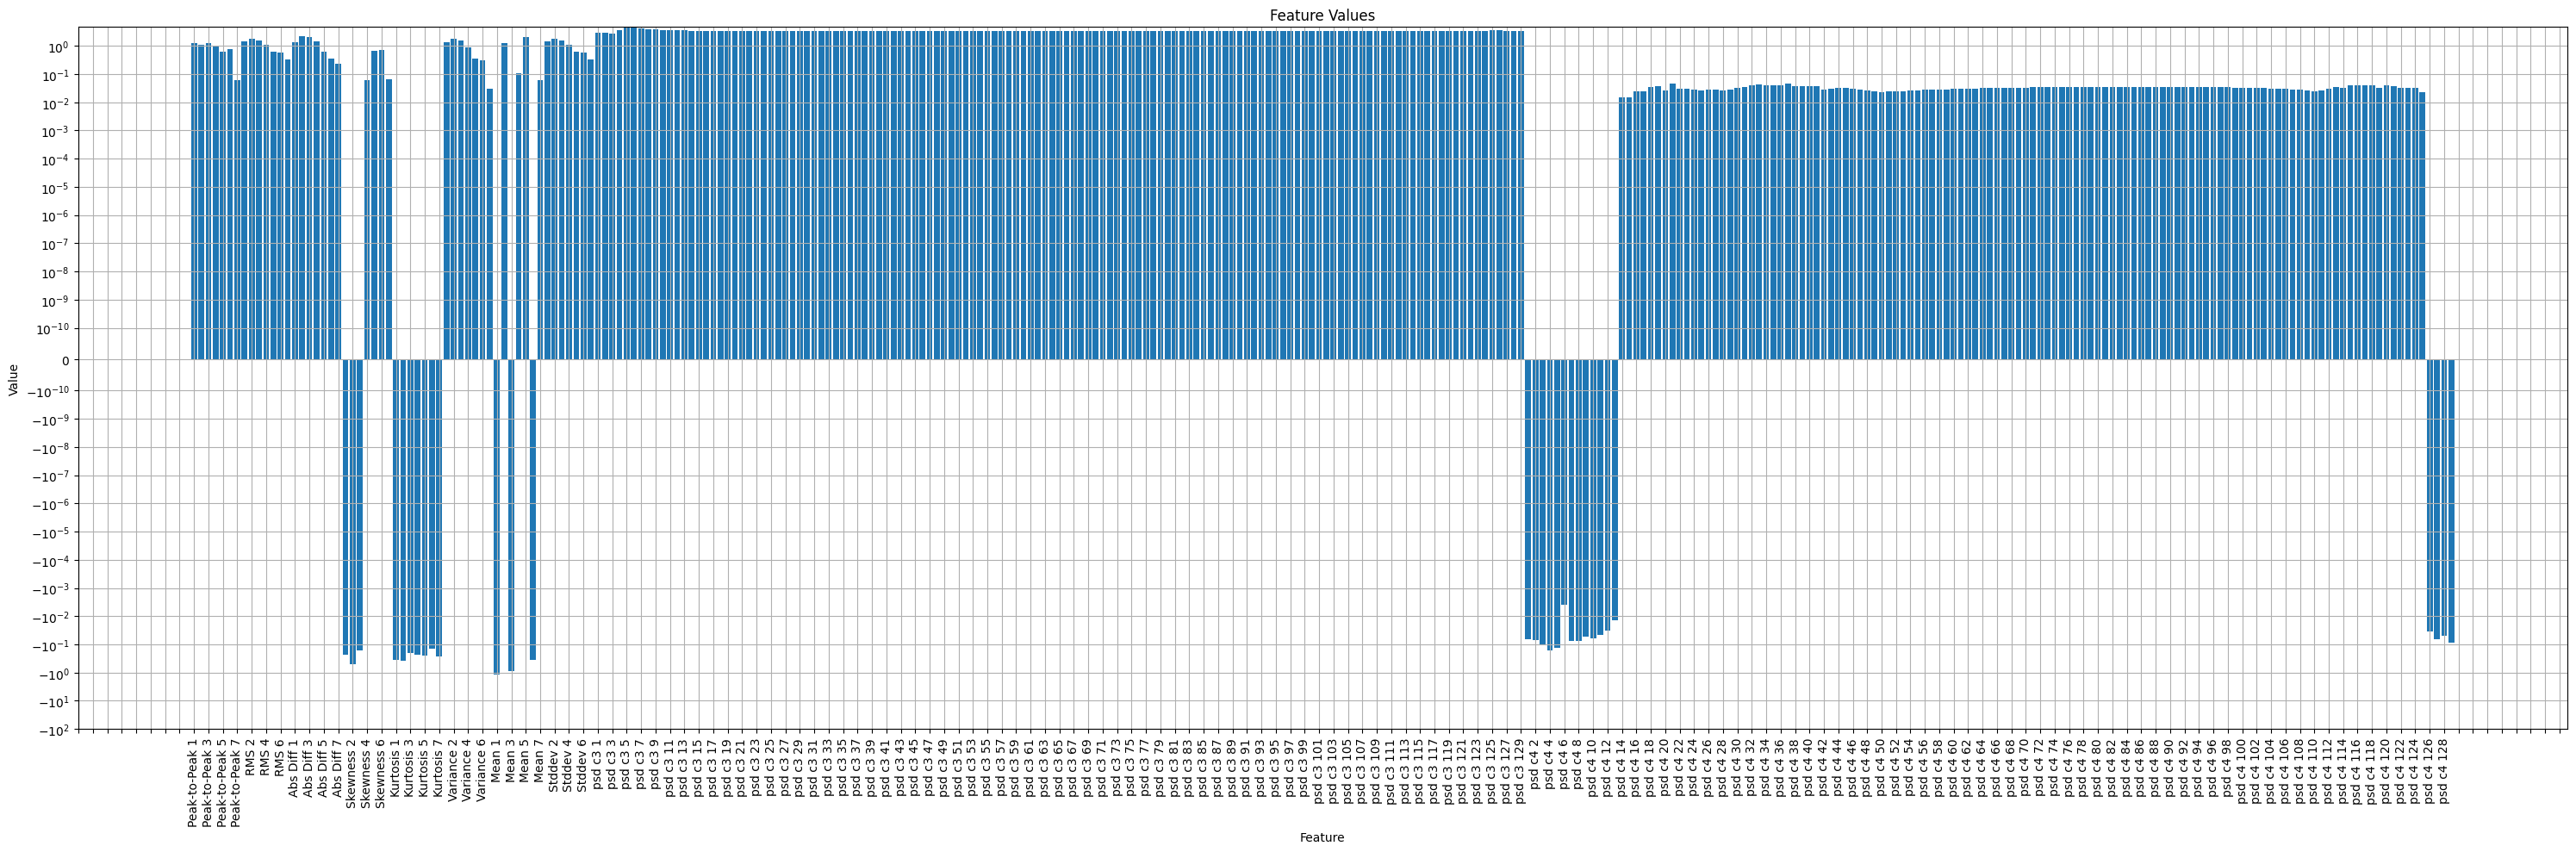

Plot 108 has been plotted
(86, 314)
(22, 314)
(86,)
(22,)
29 29 28 314


In [21]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, LayerNormalization, Reshape
from keras.optimizers import Adam,SGD
from keras.metrics import categorical_crossentropy
from keras.backend import clear_session
from matplotlib.ticker import MultipleLocator
m_features_array = np.load(file="m_features_array3_65536.npy")
r_features_array = np.load(file="r_features_array3_65536.npy")
t_features_array = np.load(file="t_features_array3_65536.npy")
features_array = np.concatenate((m_features_array,r_features_array,t_features_array))
GLOBAL_SHAPE_LENGTH = features_array.shape[1]
print(GLOBAL_SHAPE_LENGTH)
feature_names = [f'Peak-to-Peak {i+1}' for i in range(7)] + \
                [f'RMS {i+1}' for i in range(7)] + \
                [f'Abs Diff {i+1}' for i in range(7)] + \
                [f'Skewness {i+1}' for i in range(7)] + \
                [f'Kurtosis {i+1}' for i in range(7)] + \
                [f'Variance {i+1}' for i in range(7)] + \
                [f'Mean {i+1}' for i in range(7)] + \
                [f'Stddev {i+1}' for i in range(7)] + \
                [f'psd c3 {i+1}' for i in range(129)] + \
                [f'psd c4 {i+1}' for i in range(129)]



for i in [1,37,107]:
    features=features_array[i]
    print(features.shape,label_array[i])
    
    plt.figure(figsize=(30, 10))
    plt.bar(range(len(features)), features)
    plt.xticks(ticks=range(len(features)), labels=feature_names, rotation=90)
    plt.title("Feature Values")
    plt.xlabel("Feature")
    plt.ylabel("Value")
    plt.ylim(-100,max(features))
    plt.yscale("symlog",linthresh=1e-10)
    plt.grid(True)
    plt.tight_layout()
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(2))
    plt.show()
    plt.close()
    print("Plot",i+1,"has been plotted")


scaler = StandardScaler()
features_array45 = scaler.fit_transform(features_array)

for i in [1,37,107]:
    features=features_array45[i]
    print(features.shape,label_array[i])
    
    plt.figure(figsize=(30, 10))
    plt.bar(range(len(features)), features)
    plt.xticks(ticks=range(len(features)), labels=feature_names, rotation=90)
    plt.title("Feature Values")
    plt.xlabel("Feature")
    plt.ylabel("Value")
    plt.ylim(-100,max(features))
    plt.yscale("symlog",linthresh=1e-10)
    plt.grid(True)
    plt.tight_layout()
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(2))
    plt.show()
    plt.close()
    print("Plot",i+1,"has been plotted")

features_array = scaler.fit_transform(features_array)
X_train, X_test, y_train, y_test = train_test_split(features_array, label_array, test_size=.2, random_state=42, shuffle=True, stratify=label_array)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
lst = y_train.tolist()
print(lst.count(0),lst.count(1),lst.count(2),GLOBAL_SHAPE_LENGTH)
X_train2 = X_train.reshape(X_train.shape[0], GLOBAL_SHAPE_LENGTH, 1)
X_test2 = X_test.reshape(X_test.shape[0], GLOBAL_SHAPE_LENGTH, 1)
ftr2  = features_array.reshape(features_array.shape[0],GLOBAL_SHAPE_LENGTH,1)

In [22]:
class Plasticity(gym.Env):
    def __init__(self, images_per_episode=1, dataset=(X_train, y_train), random=True):
        super().__init__()

        self.action_space = gym.spaces.Discrete(3)
        self.observation_space = gym.spaces.Box(low=-3, high=3,
                                                shape=(GLOBAL_SHAPE_LENGTH,),
                                                dtype=np.float32)
        self.images_per_episode = images_per_episode
        self.step_count = 0

        self.x, self.y = dataset
        self.random = random
        self.dataset_idx = 0

    def step(self, action):

        done = False
        reward = int(action == self.expected_action)

        obs = self._next_obs()

        self.step_count += 1
        if self.step_count >= self.images_per_episode:
            done = True

        return obs, reward, done, {}

    def reset(self):
        self.step_count = 0

        obs = self._next_obs()

        return obs

    def _next_obs(self):
        if self.random:
            next_obs_idx = random.randint(0, len(self.x) - 1)
            self.expected_action = int(self.y[next_obs_idx])
            obs = self.x[next_obs_idx]
            

        else:
            obs = self.x[self.dataset_idx]
            self.expected_action = int(self.y[self.dataset_idx])
             
            self.dataset_idx += 1
            #print(f"Current dataset index: {self.dataset_idx}")
            if self.dataset_idx >= len(self.x):
                raise StopIteration()

        return obs

In [23]:
env = Plasticity()

In [24]:
env.observation_space.sample()
env.observation_space.sample().shape

(314,)

In [25]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Input
from tensorflow.keras.optimizers import Adam
tf.compat.v1.experimental.output_all_intermediates(True)

In [26]:
states = env.observation_space.shape
actions = env.action_space.n
print(states,actions)

(314,) 3


In [27]:
def build_model(states, actions):
    clear_session()
    model = Sequential([
        Reshape((GLOBAL_SHAPE_LENGTH, 1), input_shape=(1,GLOBAL_SHAPE_LENGTH)),
        BatchNormalization(),
        Conv1D(32, kernel_size=7, activation='relu',input_shape=(GLOBAL_SHAPE_LENGTH,1)),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        Conv1D(64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        LSTM(128, activation='tanh', return_sequences=True),
        BatchNormalization(),
        Flatten(),
        BatchNormalization(),
        Dense(units=256,activation='relu'),
        BatchNormalization(),
        Dense(units=128,activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(units=3,activation='softmax')
    ])
    return model

In [28]:
import tensorflow as tf
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from keras import __version__
model = build_model(states, actions)
model.summary()


Instructions for updating:
Colocations handled automatically by placer.


2023-12-10 06:42:31.144749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-10 06:42:31.145228: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 314, 1)            0         
                                                                 
 batch_normalization (Batch  (None, 314, 1)            4         
 Normalization)                                                  
                                                                 
 conv1d (Conv1D)             (None, 308, 32)           256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 154, 32)           0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 154, 32)           128       
 chNormalization)                                                
                                                        

In [29]:
def build_agent(model, actions):
    policy = EpsGreedyQPolicy(eps=1.0)
    memory = SequentialMemory(limit=30000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=100, target_model_update=1e-4)
    return dqn

In [30]:
dqn = build_agent(model, actions)
dqn.compile(tf.keras.optimizers.legacy.Adam(learning_rate=0.0055,decay=1e-3), metrics=['mse'])

2023-12-10 06:42:31.996291: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-12-10 06:42:32.083915: W tensorflow/c/c_api.cc:304] Operation '{name:'batch_normalization_2/beta/Assign' id:196 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_2/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_2/beta, batch_normalization_2/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [31]:
from rl.callbacks import Callback
print(dqn.policy.eps)
class LossHistory(Callback):
    def __init__(self):
        self.losses = []

    def on_step_end(self, step, logs={}):
        self.losses.append(logs['metrics'][0])  

class LossHistory2(Callback):
    def __init__(self):
        self.losses = []

    def on_step_end(self, step, logs={}):
        self.losses.append(logs['metrics'][1]) 

class RewardHistory(Callback):
    def on_train_begin(self, logs={}):
        self.rewards = []

    def on_episode_end(self, episode, logs={}):
        self.rewards.append(logs['episode_reward'])

class ExponentialDecayEpsilonCallback(Callback):
    def __init__(self, initial_epsilon, min_epsilon, decay_rate, decay_steps):
        self.epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.step_count = 0

    def on_step_end(self, step, logs={}):
        self.step_count += 1
        self.epsilon = self.min_epsilon + (self.epsilon - self.min_epsilon) * np.exp(-self.step_count / self.decay_steps)
        self.model.policy.eps = max(self.epsilon, self.min_epsilon)
        print(f"Step: {self.step_count}, New Epsilon: {self.epsilon}")

# Example usage
initial_epsilon = 1.0  # Starting value of epsilon
min_epsilon = 0.0  # Minimum value epsilon can reach
decay_rate = 0.01     # Rate of decay
decay_steps = 100000    # Number of steps over which epsilon decays

epsilon_decay_cb = ExponentialDecayEpsilonCallback(initial_epsilon, min_epsilon, decay_rate, decay_steps)


loss_history = LossHistory()
loss_history2 = LossHistory2()
reward_history = RewardHistory()

#, callbacks=[loss_history,loss_history2,reward_history]
dqn.fit(env, nb_steps=2000, callbacks=[loss_history,loss_history2,reward_history,epsilon_decay_cb], verbose=1)

1.0
Training for 2000 steps ...
Interval 1 (0 steps performed)


/home/eeshan/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-12-10 06:42:32.768384: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_2/Softmax' id:885 op device:{requested: '', assigned: ''} def:{{{node dense_2/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-10 06:42:32.840456: W tensorflow/c/c_api.cc:304] Operation '{name:'count_2/Assign' id:2413 op device:{requested: '', assigned: ''} def:{{{node count_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=fal

Step: 1, New Epsilon: 0.9999900000499998
    1/10000 [..............................] - ETA: 39:36 - reward: 1.0000Step: 2, New Epsilon: 0.9999700004499955
Step: 3, New Epsilon: 0.999940001799964
Step: 4, New Epsilon: 0.9999000049998333
Step: 5, New Epsilon: 0.9998500112494375
Step: 6, New Epsilon: 0.9997900220484566
Step: 7, New Epsilon: 0.9997200391963416
Step: 8, New Epsilon: 0.9996400647922247
Step: 9, New Epsilon: 0.9995501012348141
Step: 10, New Epsilon: 0.9994501512222745
Step: 11, New Epsilon: 0.9993402177520918
Step: 12, New Epsilon: 0.9992203041209233
Step: 13, New Epsilon: 0.9990904139244333
Step: 14, New Epsilon: 0.9989505510571131
   14/10000 [..............................] - ETA: 39s - reward: 0.5000  Step: 15, New Epsilon: 0.9988007197120863
Step: 16, New Epsilon: 0.9986409243808997
Step: 17, New Epsilon: 0.9984711698532985
Step: 18, New Epsilon: 0.9982914612169874
Step: 19, New Epsilon: 0.998101803857376
Step: 20, New Epsilon: 0.9979022034573098
Step: 21, New Epsilon: 

2023-12-10 06:42:33.383618: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_2_1/Softmax' id:1767 op device:{requested: '', assigned: ''} def:{{{node dense_2_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-10 06:42:33.985928: W tensorflow/c/c_api.cc:304] Operation '{name:'batch_normalization_7/cond_3/Identity' id:838 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_7/cond_3/Identity}} = Identity[T=DT_FLOAT, _has_manual_control_dependencies=true](batch_normalization_7/cond_3)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-10 06:4

Step: 102, New Epsilon: 0.94882585585315
 2000/10000 [=====>........................] - ETA: 10:08 - reward: 0.8480done, took 152.450 seconds


In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from rl.policy import GreedyQPolicy
dqn.policy = GreedyQPolicy()

def dqn_eval(dqn_agent,d):
    attempts, correct = 0, 0
    labels = d[1]
    eenv = Plasticity(dataset=d, random=False)
    thing = 1
    y_predFull = []
    y_trueest = []
    try:
        
        while True:
            
            if thing == 1:
                obs = eenv.reset()
                thing = 0
            done = False
            while not done:
                # Reshape the observation to match the input shape of the model
                obs_reshaped = np.reshape(obs, (1,) + obs.shape)
                # Get Q-values from the model
                q_values = dqn_agent.compute_q_values(obs_reshaped)
                print(q_values)
                # Select the action with the highest Q-value
                action = np.argmax(q_values)
                
                print('action: ', action, " - ", labels[attempts])
                y_predFull.append(action)
                y_trueest.append(labels[attempts])
                # Take the step using the selected action
                obs, rew, done, _ = eenv.step(action)

                if done:
                    attempts += 1
                    if rew > 0:
                        correct += 1
                    print(f"Attempt: {attempts}, Correct: {correct}")

            

    except StopIteration:
        print()
        print('Validation done...',correct+2,attempts+2)
        print('Accuracy: {:.2f}%'.format((float(correct+2) / (attempts+2)) * 100))
        # Example true and predicted values
        print(y_predFull)
        print(y_trueest)

        # Generate confusion matrix
        cm = confusion_matrix(y_trueest, y_predFull)

        # Extracting TP, TN, FP, FN
        TP = cm[1, 1]
        TN = cm[0, 0]
        FP = cm[0, 1]
        FN = cm[1, 0]

        # Calculating precision and recall
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)

        # Calculating F1 score
        F1 = 2 * (precision * recall) / (precision + recall)

        print("F1 Score:", F1)
        print("Precision: ", precision)
        print("Recall: ", recall)
    y_predFull = []
    y_trueest = []
    return (float(correct+2) / (attempts+2)), F1, precision, recall


def dqn_eval2():
     
    n_splits = 10

    
    mean_rewards_per_fold = []
    acc_per_fold = []
    f1_mean, p_mean, r_mean = [], [], []
    # Loop over each fold
    
    skf = StratifiedKFold(n_splits=n_splits)

    for train_index, test_index in skf.split(features_array,label_array):
        xtr, xte = features_array[train_index],features_array[test_index]
        ytr, yte = label_array[train_index], label_array[test_index]

        
        test_env = Plasticity(dataset = (xte, yte),random=False)
        
        scores = dqn.test(test_env, nb_episodes=1, visualize=False, verbose=0)
        acc, f1, p, r = dqn_eval(dqn,d=(xte, yte))
        
        mean_reward = np.mean(scores.history['episode_reward'])
        mean_rewards_per_fold.append(mean_reward)
        acc_per_fold.append(acc)
        f1_mean.append(f1)
        r_mean.append(r)
        p_mean.append(p)
   
    overall_mean_reward = np.mean(mean_rewards_per_fold)

    print(acc_per_fold)
    
    f1_avg, p_avg, r_avg = np.mean(f1_mean), np.mean(p_mean), np.mean(r_mean)
    print(mean_rewards_per_fold)
    print(f"Overall Mean Reward across all folds: {overall_mean_reward * 100} %")
    acc_avg = np.mean(acc_per_fold)
    print(f"Overall Mean Accuracy across all folds: {acc_avg * 100} %")
    print(f1_mean)
    print(f"Overall Mean F1 across all folds: {f1_avg * 100} %")
    print(p_mean)
    print(f"Overall Mean Precision across all folds: {p_avg * 100} %")
    print(r_mean)
    print(f"Overall Mean Recall across all folds: {r_avg * 100} %")
    
dqn_eval2()
print('***************************************************************************************')
dqn_eval(dqn,d=(features_array,label_array))
scores = dqn.test(Plasticity(dataset=(features_array,label_array),random=False), nb_episodes=10, visualize=False, verbose=0)
print(np.mean(scores.history['episode_reward'])*100,'%')

[1.0000000e+00 7.6421147e-11 2.7041416e-09]
action:  0  -  0
Attempt: 1, Correct: 1
[9.9980360e-01 1.7223730e-04 2.4142508e-05]
action:  0  -  0
Attempt: 2, Correct: 2
[9.9999988e-01 2.7216243e-10 1.0080989e-07]
action:  0  -  0
Attempt: 3, Correct: 3
[1.0000000e+00 3.7029924e-11 1.8478211e-09]
action:  0  -  0
Attempt: 4, Correct: 4
[2.4041407e-07 9.9999976e-01 3.0410799e-08]
action:  1  -  1
Attempt: 5, Correct: 5
[1.7944145e-05 9.9998164e-01 3.4302155e-07]
action:  1  -  1
Attempt: 6, Correct: 6
[9.9972636e-01 7.5898512e-05 1.9767528e-04]
action:  0  -  1
Attempt: 7, Correct: 6
[2.2284405e-03 9.9768496e-01 8.6608139e-05]
action:  1  -  1
Attempt: 8, Correct: 7
[1.0783733e-09 3.7318992e-07 9.9999964e-01]
action:  2  -  2
Attempt: 9, Correct: 8
[8.9807962e-08 3.4750393e-04 9.9965239e-01]
action:  2  -  2

Validation done... 10 11
Accuracy: 90.91%
[0, 0, 0, 0, 1, 1, 0, 1, 2, 2]
[0, 0, 0, 0, 1, 1, 1, 1, 2, 2]
F1 Score: 0.8571428571428571
Precision:  1.0
Recall:  0.75
[9.9999762e-01 1.83

[4.3179168e-04 2.1279622e-04 9.9935538e-01]
action:  2  -  1
Attempt: 7, Correct: 5
[1.7542265e-05 9.9998069e-01 1.8173722e-06]
action:  1  -  1
Attempt: 8, Correct: 6
[7.5842094e-05 1.1453129e-01 8.8539290e-01]
action:  2  -  2
Attempt: 9, Correct: 7
[4.7637199e-04 3.7824042e-04 9.9914539e-01]
action:  2  -  2

Validation done... 9 11
Accuracy: 81.82%
[0, 0, 0, 2, 1, 1, 2, 1, 2, 2]
[0, 0, 0, 0, 1, 1, 1, 1, 2, 2]
F1 Score: 1.0
Precision:  1.0
Recall:  1.0
[9.999982e-01 9.981800e-09 1.803433e-06]
action:  0  -  0
Attempt: 1, Correct: 1
[9.9976939e-01 1.0629367e-05 2.2006223e-04]
action:  0  -  0
Attempt: 2, Correct: 2
[1.0000000e+00 1.5438777e-12 4.9533400e-10]
action:  0  -  0
Attempt: 3, Correct: 3
[9.9999750e-01 2.0842906e-06 5.0006662e-07]
action:  0  -  0
Attempt: 4, Correct: 4
[9.9957448e-01 4.0724740e-04 1.8220935e-05]
action:  0  -  1
Attempt: 5, Correct: 4
[6.4245005e-06 9.9999356e-01 2.4229179e-08]
action:  1  -  1
Attempt: 6, Correct: 5
[3.4478728e-06 9.9999428e-01 2.2909769e

72.0 %


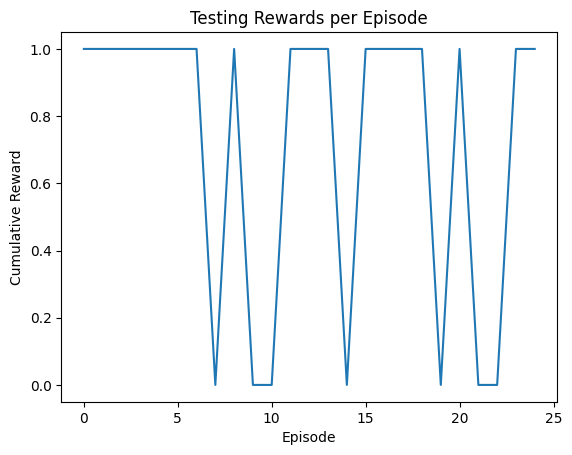

72.0 %
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] (108,)
[1.0000000e+00 7.6421147e-11 2.7041416e-09]
action:  0  -  0
Attempt: 1, Correct: 1
[9.9980360e-01 1.7223730e-04 2.4142508e-05]
action:  0  -  0
Attempt: 2, Correct: 2
[9.9999988e-01 2.7216243e-10 1.0080989e-07]
action:  0  -  0
Attempt: 3, Correct: 3
[1.0000000e+00 3.7029924e-11 1.8478211e-09]
action:  0  -  0
Attempt: 4, Correct: 4
[9.9999762e-01 1.8355987e-06 5.6518445e-07]
action:  0  -  0
Attempt: 5, Correct: 5
[9.9986565e-01 1.0275612e-04 3.1595395e-05]
action:  0  -  0
Attempt: 6, Correct: 6
[9.9757510e-01 5.6518894e-04 1.8596498e-03]
action:  0  -  0
Attempt: 7, Correct: 7
[2.2852924e-03 1.5288269e-05 9.9769944e-01]
action:  2  -  0
Attempt: 8, Correct: 7
[9.999982e-01 9.981800e-09 1.803433e-06]
action:  0  -  0
Attempt: 9, Correct: 8
[9.9976939e-0

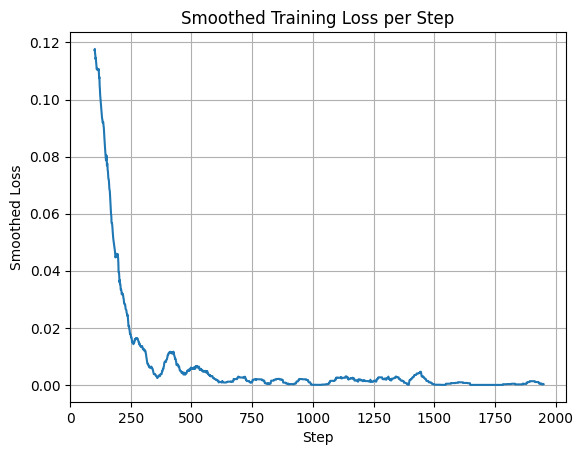

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.22645225, 0.22490859, 0.22398569, 0.2228496, 0.22101703, 0.21990068, 0.2183843, 0.21756199, 0.21724428, 0.21708615, 0.2166672, 0.21582693, 0.21569936, 0.21521243, 0.21423063, 0.2142048, 0.21285605, 0.21211109, 0.21202135, 0.21150197, 0.21122849, 0.21062031, 0.21079387, 0.21118645, 0.210806, 0.20968293, 0.21010314, 0.21073496, 0.21103974, 0.21311085, 0.21260905, 0.21235867, 0.21302064, 0.21284606, 0.21187183, 0.21284644, 0.21254864, 0.21193506, 0.2111528, 0.21035473, 0.20988116, 0.2094859

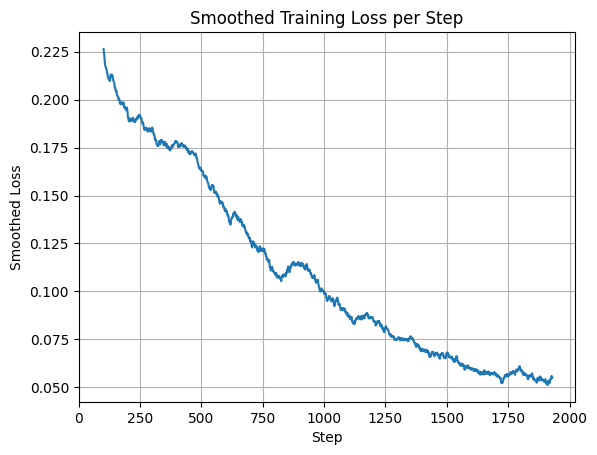

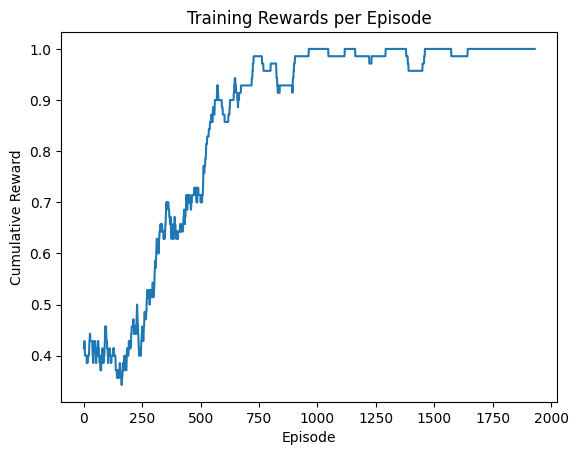

___________________________________________________________________________________________________________________________


In [33]:
rwd = RewardHistory()
scores = dqn.test(env=Plasticity(dataset=(features_array,label_array),random=False), nb_episodes=25, visualize=False, callbacks=[rwd],verbose=0)
print(np.mean(scores.history['episode_reward'])*100,'%')
plt.plot(scores.history['episode_reward'])
plt.title('Testing Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.show()
print(np.mean(scores.history['episode_reward'])*100,'%')
print(label_array,label_array.shape)

dqn_eval(dqn,d=(features_array,label_array))
def moving_average(data, window_size):
    return [np.mean(data[i:i+window_size]) for i in range(len(data) - window_size + 1)]
losses = loss_history.losses
losses2 = loss_history2.losses
smoothed_losses = moving_average(losses, window_size=50)  
print(smoothed_losses)
plt.plot(smoothed_losses)
plt.title('Smoothed Training Loss per Step')
plt.xlabel('Step')
plt.xlim(left=0)
plt.ylabel('Smoothed Loss')
plt.grid(True)
plt.show()

smoothed_losses2 = moving_average(losses2, window_size=70)  
print(smoothed_losses2)
plt.plot(smoothed_losses2)
plt.title('Smoothed Training Loss per Step')
plt.xlabel('Step')
plt.xlim(left=0)
plt.ylabel('Smoothed Loss')
plt.grid(True)
plt.show()

plt.plot(moving_average(reward_history.rewards, window_size=70))
plt.title('Training Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.show()

print("___________________________________________________________________________________________________________________________")

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Example true and predicted values
print(y_predFull)
print(y_trueest)

# Generate confusion matrix
cm = confusion_matrix(y_trueest, y_predFull)

# Extracting TP, TN, FP, FN
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

# Calculating precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)

# Calculating F1 score
F1 = 2 * (precision * recall) / (precision + recall)

print("F1 Score:", F1)
print("Precision: ", precision)
print("Recall: ", recall)


NameError: name 'y_predFull' is not defined